In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import os
import time
from datetime import datetime, timedelta

from google.colab import drive

LOADED = True

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Specify the folder path in Google Drive
folder_path = '/content/drive/MyDrive/mimic_csvs'

# Individual csv paths
admissions_path = os.path.join(folder_path, 'ADMISSIONS.csv')
icu_stays_path = os.path.join(folder_path, 'ICUSTAYS.csv')
patients_path = os.path.join(folder_path, 'PATIENTS.csv')
chart_events_path = os.path.join(folder_path, 'CHARTEVENTS.csv')
complete_data_path = os.path.join(folder_path, 'mimic_complete_data.csv')

Mounted at /content/drive


In [2]:
# Model parameters and outcome
# hadm_id as primary key to predict by hosptial visit rather than by patient

if not LOADED:
  data = {
    'hadm_id': [],
    'subject_id': [],
    'gender': [],
    'age': [],
    'marital_status': [],
    'ethnicity': [],
    'diagnosis': [],
    'vitals': [],
    'icu_admitted': []
  }


In [3]:
# Load hadm_id, subject_id, ethnicity, marital_status, diagnosis from ADMISSIONS.CSV

if not LOADED:
  if not os.path.exists(admissions_path):
    raise FileNotFoundError(f"File not found: {admissions_path}")

  admissions_df = pd.read_csv(admissions_path)
  data['hadm_id'] = admissions_df['HADM_ID'].tolist()
  data['ethnicity'] = admissions_df['ETHNICITY'].tolist()
  data['diagnosis'] = admissions_df['DIAGNOSIS'].tolist()
  data['marital_status'] = admissions_df['MARITAL_STATUS'].tolist()
  data['subject_id'] = admissions_df['SUBJECT_ID'].tolist()

  row_count = total_data_points = len(data['hadm_id'])

  # Load gender, age (at time of visit) from PATIENTS.CSV
  if not os.path.exists(patients_path):
    raise FileNotFoundError(f"File not found: {patients_path}")

  patients_df = pd.read_csv(patients_path)
  for i in range(row_count):
    subject_id = data['subject_id'][i]
    hadm_id = data['hadm_id'][i]

    gender = patients_df[patients_df['SUBJECT_ID'] == subject_id]['GENDER'].values[0]
    data['gender'].append(gender)

    dob = patients_df[patients_df['SUBJECT_ID'] == subject_id]['DOB'].values[0]
    admittime = admissions_df[admissions_df['HADM_ID'] == hadm_id]['ADMITTIME'].values[0]

    dob_dt = datetime.strptime(str(dob)[:10], '%Y-%m-%d')
    admit_dt = datetime.strptime(str(admittime)[:10], '%Y-%m-%d')

    age = (admit_dt - dob_dt).days // 365  # Convert days to years

    data['age'].append(age)

  # Load ICU stays
  if not os.path.exists(icu_stays_path):
    raise FileNotFoundError(f"File not found: {icu_stays_path}")

  icustays_df = pd.read_csv(icu_stays_path)
  icu_hadm_ids = set(icustays_df['HADM_ID'].tolist())

  # Check if each hadm_id is in the ICU stays
  data['icu_admitted'] = [hadm_id in icu_hadm_ids for hadm_id in data['hadm_id']]

In [4]:
# Load Vitals Data - First 24 hours after hospital admission time
# Each data['vitals'] entry format = [heart_rate_mean, sbp_mean, dbp_mean, temp_mean, resp_rate_mean, spo2_mean]

if not LOADED:
  if not os.path.exists(chart_events_path):
    raise FileNotFoundError(f"File not found: {chart_events_path}")

  data['vitals'] = [None] * row_count

  # Vital sign ITEMIDs corresponding to required vitals parameters
  vital_itemids = {
      'heart_rate': [211, 220045],
      'systolic_bp': [51, 442, 455, 6701, 220179, 220050],
      'diastolic_bp': [8368, 8440, 8441, 8555, 220180, 220051],
      'temp': [223761, 678],
      'resp_rate': [618, 615, 220210, 224690],
      'spo2': [646, 220277]
  }

  # Flatten all vital ITEMIDs into one list
  all_vital_ids = [item for items in vital_itemids.values() for item in items]

  # Load CHARTEVENTS in chunks
  # Filter rows by keeping only parameter vital types and hadm_ids in data
  chunk_size = 500000
  filtered_chunks = []

  print("Loading CHARTEVENTS in chunks...")
  for i, chunk in enumerate(pd.read_csv(chart_events_path, chunksize=chunk_size)):
      print(f"Processing chunk {i+1}...")

      # Keep only rows with parameter vital type ITEMIDs
      chunk_filtered = chunk[chunk['ITEMID'].isin(all_vital_ids)]

      # Keep only rows for hadm_ids in data
      chunk_filtered = chunk_filtered[chunk_filtered['HADM_ID'].isin(data['hadm_id'])]
      filtered_chunks.append(chunk_filtered)

  # Combine all filtered chunks
  vitals_df = pd.concat(filtered_chunks, ignore_index=True)
  print(f"Loaded {len(vitals_df)} vital sign records")

  # Convert times to datetime format
  vitals_df['CHARTTIME'] = pd.to_datetime(vitals_df['CHARTTIME'])
  admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])

  # Merge admission times onto vitals (one-time operation)
  vitals_df = vitals_df.merge(
      admissions_df[['HADM_ID', 'ADMITTIME']],
      on='HADM_ID',
      how='left'
  )

  # Filter to first 24 hours
  vitals_df['time_diff_hours'] = (vitals_df['CHARTTIME'] - vitals_df['ADMITTIME']).dt.total_seconds() / 3600
  vitals_df_24hr = vitals_df[(vitals_df['time_diff_hours'] >= 0) & (vitals_df['time_diff_hours'] <= 24)]

  # Map ITEMIDs to vital names
  itemid_to_vital = {}
  for vital_name, item_ids in vital_itemids.items():
      for item_id in item_ids:
          itemid_to_vital[item_id] = vital_name

  vitals_df_24hr['vital_type'] = vitals_df_24hr['ITEMID'].map(itemid_to_vital)

  # Group and calculate means (vectorized)
  vitals_summary = vitals_df_24hr.groupby(['HADM_ID', 'vital_type'])['VALUENUM'].mean().unstack(fill_value=None)

  # Ensure columns are in correct order
  vital_order = ['heart_rate', 'systolic_bp', 'diastolic_bp', 'temp', 'resp_rate', 'spo2']
  vitals_summary = vitals_summary.reindex(columns=vital_order)

  # Fill data['vitals'] in correct order
  for i in range(row_count):
      hadm_id = data['hadm_id'][i]
      if hadm_id in vitals_summary.index:
          data['vitals'][i] = vitals_summary.loc[hadm_id].tolist()
      else:
          data['vitals'][i] = [None] * 6

In [5]:
def safe_eval(x):
    try:
        return ast.literal_eval(x) if pd.notna(x) else [None]*6
    except:
        return [None]*6

In [6]:
# View Data Frame and save complete dataset to CSV

if not LOADED:
  df = pd.DataFrame(data)
  df.to_csv(complete_data_path, index=False)
  print('data saved to mimic_complete_data.csv')
else:
  df = pd.read_csv(complete_data_path)
  df['vitals'] = df['vitals'].apply(safe_eval)
  print('data loaded from mimic_complete_data.csv')

total_data_points = len(df)
column_count = len(df.columns)
print(f"Total number of data points: {total_data_points}\n\nData Frame:")
print(df)

data loaded from mimic_complete_data.csv
Total number of data points: 58976

Data Frame:
       hadm_id  subject_id gender  age marital_status ethnicity  \
0       165315          22      F   64        MARRIED     WHITE   
1       152223          23      M   71        MARRIED     WHITE   
2       124321          23      M   75        MARRIED     WHITE   
3       161859          24      M   39         SINGLE     WHITE   
4       129635          25      M   58        MARRIED     WHITE   
...        ...         ...    ...  ...            ...       ...   
58971   191113       98800      F   19         SINGLE     WHITE   
58972   101071       98802      F   83        WIDOWED     WHITE   
58973   122631       98805      M   42        MARRIED     WHITE   
58974   170407       98813      F   60        MARRIED     WHITE   
58975   190264       98813      F   63        MARRIED     WHITE   

                                               diagnosis  \
0                                BENZODIAZEPIN

In [7]:
# Cleaning and Preprocess

# PHASE A: CLEANING

# 0) Handle missing main category data
df = df[df['diagnosis'].notna()]
df['marital_status'] = df['marital_status'].fillna('Not Disclosed') # Treat missing marital status as new category "Not Disclosed"

# 1) Convert list of vitals into separate columns
vitals_df = pd.DataFrame(df['vitals'].tolist(),
                         columns=['hr_mean', 'sbp_mean', 'dbp_mean',
                                 'temp_mean', 'rr_mean', 'spo2_mean'],
                         index=df.index)

# 2) Create a singular X (the inputs) and y (the target)
X = pd.concat([df[['age', 'gender', 'marital_status', 'ethnicity', 'diagnosis']], vitals_df], axis=1)
y = df['icu_admitted'].astype(int)

# 3) Split the data before statistical learning to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# PHASE B: PREPROCESSING

# 4) Process data differently based on their data type, this handles imputation, scaling, encoding, and vectorizing
preprocessor = ColumnTransformer(
    transformers=[
        # Impute vitals and then scale them
        ('vitals_num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), ['hr_mean', 'sbp_mean', 'dbp_mean', 'temp_mean', 'rr_mean', 'spo2_mean']),

        # Scale age
        ('age_num', StandardScaler(), ['age']),

        # One-Hot Encode categories
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['gender', 'marital_status', 'ethnicity']),

        # Vectorize diagnosis text
        ('text', TfidfVectorizer(max_features=100, stop_words='english'), 'diagnosis')
    ])

# 5) Fit on training, and transform both
X_train_final = preprocessor.fit_transform(X_train).toarray()
X_test_final = preprocessor.transform(X_test).toarray()

In [8]:
# Initialize Supervised Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

sup_models = {
    'Logistical Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=0),
    'Support Vector Machine': SVC(probability=True, random_state=0),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}


In [9]:
# Initialize Unsupervised Models (Not really of use since we have a definitive target)

unsup_models = {

}

In [10]:
# Store Metrics

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)

metrics = {
    "Model": [],
    "Accuracy": [],           # Percentage of total correct predictions
    "Precision": [],          # Percentage of predicted ICU admitted correctly requiring ICU (Focuses on False Positives)
    "Recall": [],             # Percentage of ICU requiring patients correctly identified as such (Focuses on False Negitives)
    "F1 Score": [],           # Balance of precision/recall
    "ROC-AUC": [],
    "PR-AUC": [],
    "Specificity": [],        # Percentage of Non-ICU admitted patients predicted as such
    "Training Time (s)": [],
    "Prediction Time (s)": []
}

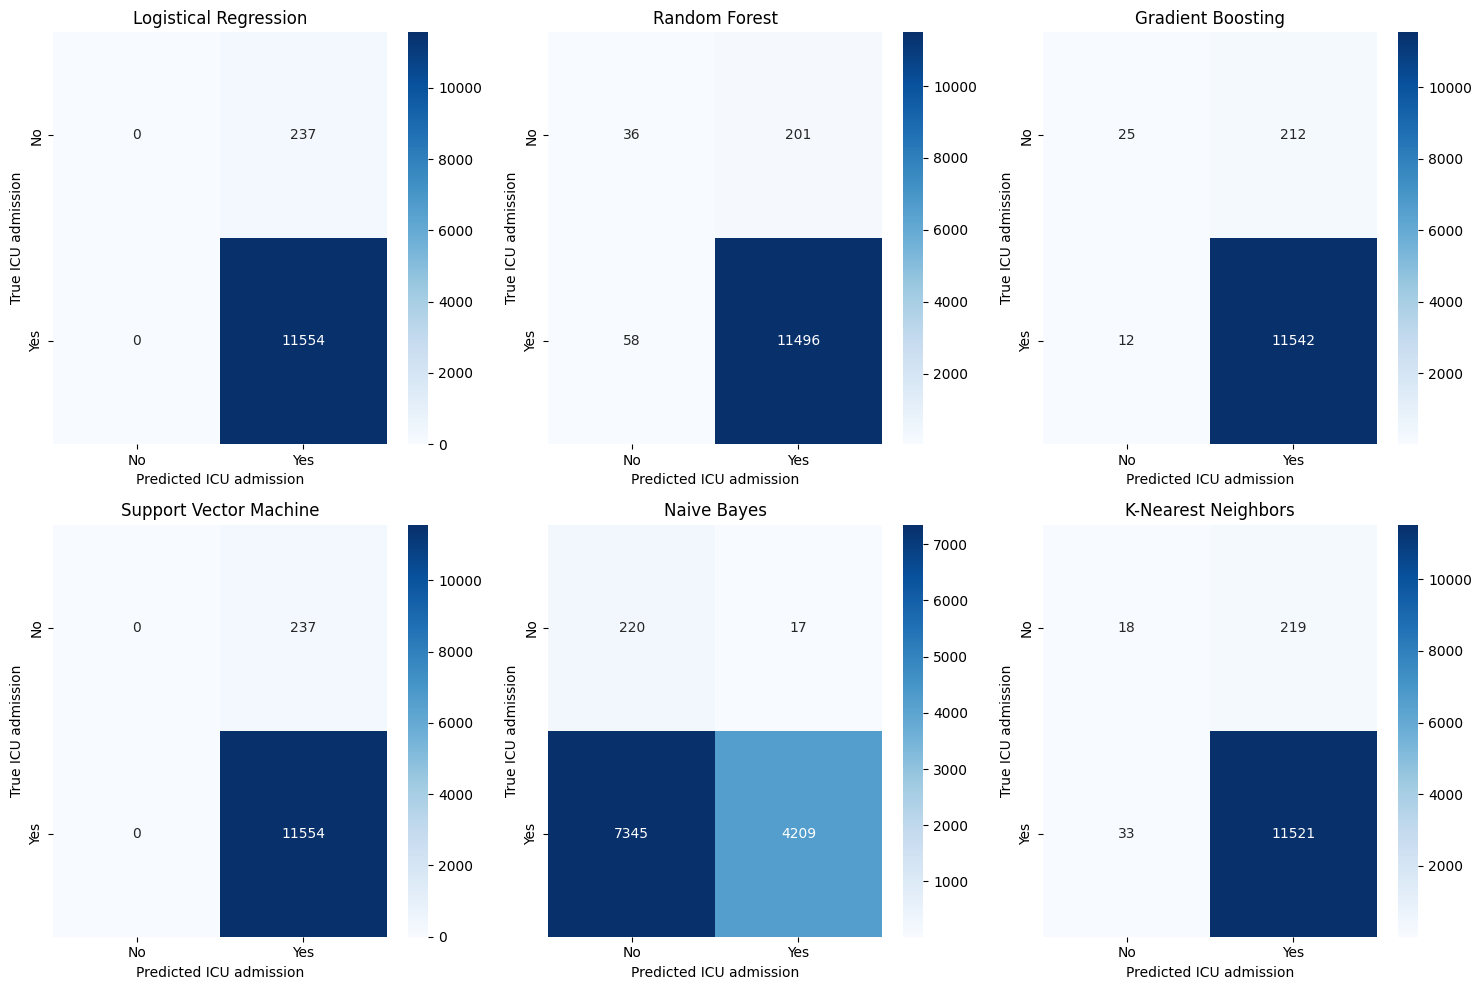

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC,PR-AUC,Specificity,Training Time (s),Prediction Time (s)
0,Logistical Regression,0.979900,0.979900,1.000000,0.989848,0.870311,0.996443,0.000000,0.877320,0.017896
1,Random Forest,0.978034,0.982816,0.994980,0.988861,0.869137,0.995357,0.151899,5.948558,0.232902
2,Gradient Boosting,0.981002,0.981964,0.998961,0.990390,0.927164,0.997738,0.105485,25.785991,0.028031
3,Support Vector Machine,0.979900,0.979900,1.000000,0.989848,0.842691,0.995746,0.000000,193.959173,9.005790
4,Naive Bayes,0.375625,0.995977,0.364289,0.533460,0.853739,0.995025,0.928270,0.058352,0.024841
5,K-Nearest Neighbors,0.978628,0.981346,0.997144,0.989182,0.691984,0.987583,0.075949,0.004389,3.099962


In [11]:
# Plotting confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(sup_models.items()):
    # Train model and measure time
    start_train = time.time()
    model.fit(X_train_final, y_train)
    train_time = time.time() - start_train

    # Model prediction and measure time
    start_pred = time.time()
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    pred_time = time.time() - start_pred

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=axes[i], cmap='Blues')
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted ICU admission')
    axes[i].set_ylabel('True ICU admission')
    axes[i].set_xticklabels(['No', 'Yes'])
    axes[i].set_yticklabels(['No', 'Yes'])

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    # Store metrics
    metrics["Model"].append(name)
    metrics["F1 Score"].append(f1)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["Accuracy"].append(accuracy)
    metrics["ROC-AUC"].append(roc_auc)
    metrics["PR-AUC"].append(pr_auc)
    metrics["Specificity"].append(specificity)
    metrics["Training Time (s)"].append(train_time)
    metrics["Prediction Time (s)"].append(pred_time)

# Adjust layout
plt.tight_layout()
plt.show()

# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
metrics_df